## Trabalho Prático 3 - Introdução à Computação Visual

Aluno: Lucas Resende Pellegrinelli Machado

Matrícula: 2018126673

### Importações das bibliotecas utilizadas (Tensorflow, numpy, matplotlib e sklearn)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D, Activation

from sklearn.metrics import classification_report, confusion_matrix

### Préprocessamento dos dados

No bloco abaixo são feitas as correções de ```shape``` dos dados e a normalização dos mesmos. Para as redes convolucionais (tanto LeNet-5 quanto a criada por mim), a entrada deverá ser no formato ```(?, 32, 32, 3)``` visto que teremos como entrada uma imagem de 32x32 pixels com 3 cores em cada.

Já para a MLP, a entrada deve ser unidimensional, logo os dados deverão ser reorganizados de forma que as dimensões dos dados representem um versão planificada dos mesmos, gerando dimensões ```(?, 32 * 32 * 3) = (?, 3072)``` como a entrada para a rede neural.

Também foi feita uma normalização dos dados visto que naturalmente essa é uma boa prática ao desenvolver algoritmos de aprendizado de máquina. Para isso foi dividido o valor de cada um dos canais de cores de cada um dos pixels (que vão de 0 até 255) por 255 para que ao final seus valores ficassem no intervalo ```(0, 1)```.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

one_hot_y_train = np.squeeze(tf.one_hot(y_train, depth=10), 1)
one_hot_y_test = np.squeeze(tf.one_hot(y_test, depth=10), 1)

conv_x_train = np.array(x_train).astype('float32')
conv_y_train = np.array(one_hot_y_train).astype('float32')
conv_x_test = np.array(x_test).astype('float32')
conv_y_test = np.array(one_hot_y_test).astype('float32')

print("conv_x_train shape", conv_x_train.shape)
print("conv_y_train shape", conv_y_train.shape)
print("conv_x_test shape", conv_x_test.shape)
print("conv_y_test shape", conv_y_test.shape)

mlp_x_train = conv_x_train.reshape(conv_x_train.shape[0], np.prod(conv_x_train.shape[1:]))
mlp_y_train = np.copy(conv_y_train)
mlp_x_test = conv_x_test.reshape(conv_x_test.shape[0], np.prod(conv_x_test.shape[1:]))
mlp_y_test = np.copy(conv_y_test)

print("mlp_x_train shape", mlp_x_train.shape)
print("mlp_y_train shape", mlp_y_train.shape)
print("mlp_x_test shape", mlp_x_test.shape)
print("mlp_y_train shape", mlp_y_test.shape)

conv_x_train shape (50000, 32, 32, 3)
conv_y_train shape (50000, 10)
conv_x_test shape (10000, 32, 32, 3)
conv_y_test shape (10000, 10)
mlp_x_train shape (50000, 3072)
mlp_y_train shape (50000, 10)
mlp_x_test shape (10000, 3072)
mlp_y_train shape (10000, 10)


### Rede Neural - Multi layer perceptron

Na célula abaixo é definida e treinada a rede neural "comum", que não utiliza de convoluções. Essa rede é uma rede simples utilizando a ativação ```relu``` em cada uma de suas camadas (tirando a última, que utiliza a função ```softmax``` para possibilitar a classificação) e tem 3 camadas escondidas com ```64```, ```128``` e ```64``` neurônios respectivamente.

Para a função de erro foi utilizada a ```categorical_crossentropy``` que é a função utilizada para classificação categórica de dados e o otimizador ```adam``` que é um otimizador que em geral funciona bem para a maioria dos problemas.

In [3]:
mlp_model = Sequential([
    Dense(32, activation="relu", input_dim=mlp_x_train.shape[1]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(mlp_y_train.shape[1], activation="softmax")
])

mlp_model.summary()
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    mlp_history = mlp_model.fit(mlp_x_train, mlp_y_train, batch_size=256, epochs=50, validation_data=(mlp_x_test, mlp_y_test), verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 102,858
Trainable params: 102,858
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 - 3s - loss: 2.0314 - accuracy: 0.2482 - val_loss: 1.9046 - val_accuracy: 0.2985
Epoch 2/50
196/196 - 1s - loss: 1.8608 - accuracy: 0.3194 - val_loss: 1.8201 - val_accuracy: 0.3332
Epoch 3/50
196/196 - 1s - loss: 1.8122 - accurac

### Rede Neural - Convolucional

Já na célula abaixo temos a definição da rede neural convolutional utilizada. A definição foi dividida em 4 blocos, sendo 3 deles blocos convolucionais e o último um bloco totalmente conectado que de fato faz a classificação das classes.

Nos blocos convolucionais foram utilizados uma camada convolucional com uma função ```relu``` após ela e uma camada de pooling (mais especificamente a ```AveragePooling2D```) em seguida. Após 3 dessas camadas com ```16```, ```16``` e ```32``` kernels respectivamente, planificamos a saída com a camada ```Flatten``` e, após uma ativação ```relu```, conectamos de forma densa à camada final com 10 neurônios correspondendo às classes de saída.

De novo foi utilizada a função ```categorical_crossentropy``` para a função de erro e o otimizador ```adam``` pelas mesmas razões.

In [4]:
conv_model = Sequential([
    Conv2D(16, 3, input_shape=conv_x_train.shape[1:], padding="same"),
    Activation("relu"),
    AveragePooling2D(),
    
    Conv2D(16, 3, padding="same"),
    Activation("relu"),
    AveragePooling2D(),
    
    Conv2D(32, 3, padding="same"),
    Activation("relu"),
    AveragePooling2D(),
    
    Flatten(),
    Activation("relu"),
    Dense(conv_y_train.shape[1]),
    Activation("softmax")
])

conv_model.summary()
conv_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    conv_history = conv_model.fit(conv_x_train, conv_y_train, batch_size=256, epochs=50, validation_data=(conv_x_test, conv_y_test), verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)         

### Rede Neural - LeNet5

Aqui temos uma implementação da rede LeNet5. Ela pode ser descrita pelo diagrama a seguir.

<img src="https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png" width="750px">

Como pode ser observado pelo ```summary``` mostrado pelo keras do modelo criado, todas as dimensões e camadas estão de acordo com a imagem acima.

Como funções de ativação foram utilizadas ```relu``` por ser a mais popular nesse tipo de tarefa e o ```AveragePooling2D``` para os poolings por ser a camada de pooling que atingiu os melhores resultados nos testes feitos.

In [5]:
lenet5_model = Sequential([
    Conv2D(6, 5, input_shape=conv_x_train.shape[1:], activation='relu'),
    AveragePooling2D(),
    Conv2D(16, 5, activation="relu"),
    AveragePooling2D(),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(conv_y_train.shape[1], activation='softmax')
])

lenet5_model.summary()
lenet5_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    lenet5_history = lenet5_model.fit(conv_x_train, conv_y_train, batch_size=256, epochs=50, validation_data=(conv_x_test, conv_y_test), verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_3 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

### Erro e acurácia para os dados de treino

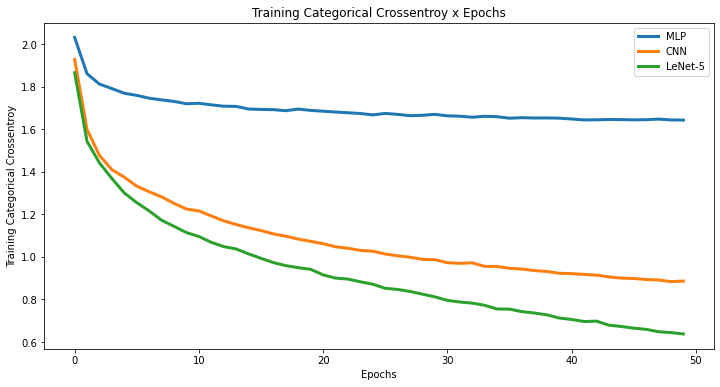

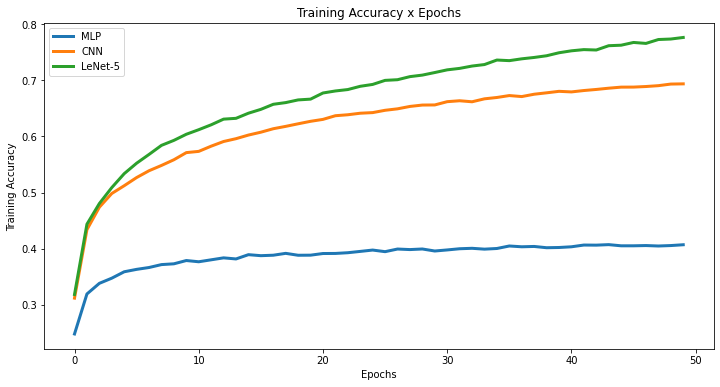

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history["loss"], label="MLP", linewidth=3)
plt.plot(conv_history.history["loss"], label="CNN", linewidth=3)
plt.plot(lenet5_history.history["loss"], label="LeNet-5", linewidth=3)
plt.legend(loc="best")
plt.title("Training Categorical Crossentroy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Categorical Crossentroy")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history["accuracy"], label="MLP", linewidth=3)
plt.plot(conv_history.history["accuracy"], label="CNN", linewidth=3)
plt.plot(lenet5_history.history["accuracy"], label="LeNet-5", linewidth=3)
plt.legend(loc="best")
plt.title("Training Accuracy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

### Erro e acurácia para os dados de validação

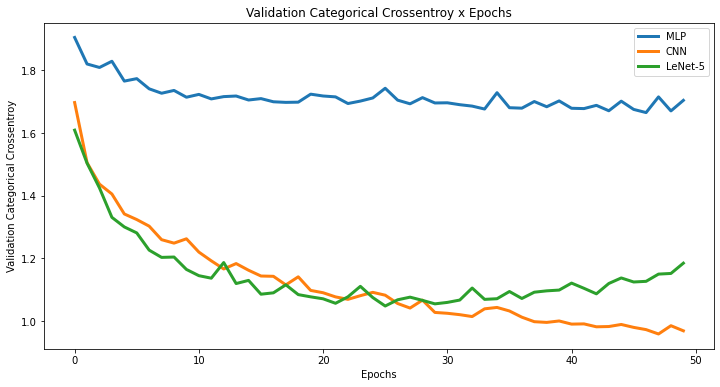

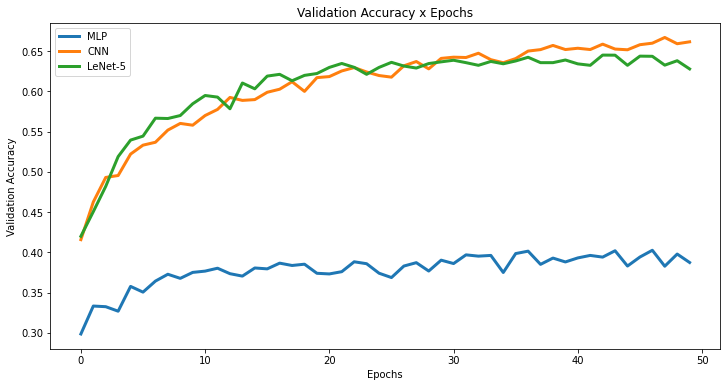

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history["val_loss"], label="MLP", linewidth=3)
plt.plot(conv_history.history["val_loss"], label="CNN", linewidth=3)
plt.plot(lenet5_history.history["val_loss"], label="LeNet-5", linewidth=3)
plt.legend(loc="best")
plt.title("Validation Categorical Crossentroy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Categorical Crossentroy")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(mlp_history.history["val_accuracy"], label="MLP", linewidth=3)
plt.plot(conv_history.history["val_accuracy"], label="CNN", linewidth=3)
plt.plot(lenet5_history.history["val_accuracy"], label="LeNet-5", linewidth=3)
plt.legend(loc="best")
plt.title("Validation Accuracy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

### Matrizes de confusão para os dados de validação

In [8]:
mlp_orig = np.argmax(mlp_y_test, axis=1)
conv_orig = np.argmax(conv_y_test, axis=1)

mlp_pred = np.argmax(mlp_model.predict(mlp_x_test), axis=1)
cnn_pred = np.argmax(conv_model.predict(conv_x_test), axis=1)
lenet_pred = np.argmax(lenet5_model.predict(conv_x_test), axis=1)

print("Matriz de confusão para MLP")
print(confusion_matrix(mlp_orig, mlp_pred))

print("\nMatriz de confusão para CNN")
print(confusion_matrix(conv_orig, cnn_pred))

print("\nMatriz de confusão para LeNet5")
print(confusion_matrix(conv_orig, lenet_pred))

Matriz de confusão para MLP
[[430  29  75  73  27  37  29  95 187  18]
 [ 51 468  21  80  35  31  49  63  81 121]
 [ 81  27 172  93 170 101 172 143  33   8]
 [ 19  25  85 187  80 232 228  93  19  32]
 [ 47  13 103  74 305  73 211 148  19   7]
 [  7  17  76 140  94 345 167 100  35  19]
 [  2  20  63  88 103  91 581  32   7  13]
 [ 22  15  73  46 109  80  63 511  39  42]
 [129  72   9  98  13  80  11  34 492  62]
 [ 66 157  11  74   8  26  47  96 133 382]]

Matriz de confusão para CNN
[[696  19  44   9  31  15   9  24  95  58]
 [ 23 734   7   8   6   4   8   9  34 167]
 [ 75   4 470  49 134 104  62  62  20  20]
 [ 21  11  69 342 114 279  62  53  24  25]
 [ 15   3  51  31 666  56  36 116  21   5]
 [ 11   1  41  93  66 673  22  65  17  11]
 [ 10   6  41  51  89  57 699  14  12  21]
 [ 15   4  18  23  80  73   7 751   7  22]
 [ 74  30  16  15  12   9   2   5 802  35]
 [ 33  79   7  13   7  14  10  21  34 782]]

Matriz de confusão para LeNet5
[[736  26  62  17  12   7  19   3  79  39]
 [ 29 

### Como encontrei os hiperparâmetros e arquitetura

Para a rede neural baseada em multi layer perceptron, defini uma quantidade de camadas escondidads e reduzi a quantidade de neurônios em cada até que os resultados obtidos começaram a diminuir, o que resultou nos parâmetros utilizados.

Para a CNN, eu queria uma rede com poucos parâmetros, então a quantidade de kernels é baixa em cada camada convolucional e eu evitei adicionar mais camadas totalmente conectadas além da camada de saída visto que essas são as que mais influenciam na quantidade de parâmetros a serem treinados em uma rede neural.

O batch size de 256 escolhido vem de recomendações encontradas online para a placa de vídeo que utilizei para o treinamento das redes, sendo um valor balanceado.

### Conclusão

Nesse trabalho foram comparados 3 arquiteturas de redes neurais para a classificação de imagens do dataset CIFAR-10. Como esperado, as arquiteturas baseadas em redes neurais convolucionais conseguiram resultados de acurácia bem melhores que a arquitetura Multi Layer Perceptron.

Dentre as duas arquiteturas convolucionais, nas primeiras épocas ambas foram bem parecidas mas a LeNet-5 começou a sofrer com overfit mais cedo do que a arquitetura proposta por mim. Isso pode ser obsertado no gráfico de ```Validation Loss x Epochs``` que mostra que a partir da época 25 a LeNet parou de melhorar e com o tempo foi até piorando essa métrica devido ao overfit. A rede convolucional proposta continuou ao longo das 50 épocas diminuindo o erro de validação e aumentando a acurácia.

De forma geral os resultados esperados foram obtidos e serviram como uma boa demonstração das vantagem de se utilizar uma rede convolucional para tarefas como essa.